# Binning. Straighten your data

## Introduction & Motivation

Binning is the common name for the set of approaches we can use for feature possible values range reducing. For example, we can split the continuous feature range into several parts and treat it like the categorical one. On the other side, we can merge some classes of the categorical variable. But why?

First of all, the reasons depend on the type of feature we bin. For categorical ones, it's not good if we don't have enough observations in some classes. So our model won't be able to make confident predictions for this class (underfitting). Also binning is obviously effective mean against outliers in numerical features: every extremely huge or small characteristic value is hidden as another instance of the top or bottom bin.

It's especially important that binning allows us to find and process non-monotonicity in numerical variables and hence we can make linear models work better without resorting to unstable and uninterpretable polynomial features.

Another point of linear model improvement and the common advantage of the binning technique for both categorical and numerical features is missing values processing. Also, you can get a deeper understanding of your data and make feature selection using some special metrics for binning results evaluation.

The most popular application of binning is a bank scorecard building. So in the tutorial, we will talk about the task - binary classification (are customer good or bad?) and the model - logistic regression. But I'm sure that these concepts are applicable for linear regression tasks too.

So, how does it work?

## Short Algorithms Review

The bank scoring theoretician Lyn C. Thomas said that binning technique "is as much art as it is science". That's true and obviously, there are many algorithms of binning.

Trivial way is splitting into equal parts. We can do it cutting the range into intervals with equal width (same variable band into each bin) or with equal size (same number of observations).  But these methods don't count target distribution at all. Also, we don't have any criteria for the choice of optimal split-points.

The more advanced path is to apply powerful statistical tests. The main idea is quite simple too.

OK, we start with our previous step and for clarity let's split feature range into a number of the smallest intervals (one observation in each bin). As we mentioned in the introduction we are deciding a binary classification task, such as prediction of bank delinquencies. So we can write a target value 1 or 2 (for good and bad clients respectively) in every small bin on a training set. After adding the column of feature values we should arrange our table in feature ascending order. Imagine that we got something like this.

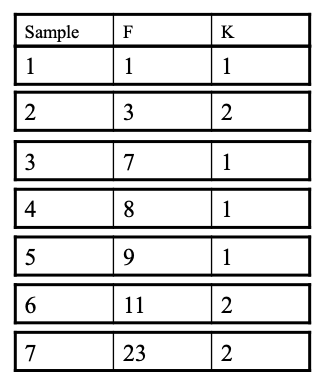

Now for every pair of adjacent bins, we can build a contingency table. It presents a frequency distribution of instances among two binary variables: the bin in pair and the target value.

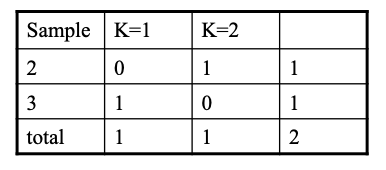

Statistics is starting! We are looking for similar pairs of adjacent bins to merge them, isn't it? So our null hypothesis stating is that bins have the same one-two frequency distribution and observed difference arose by chance. Let's compute expected values of frequency in this case (don't scare they can be fractions!) and check for every pair how far it from being siblings. We can do it using Pearson's chi-squared distance.

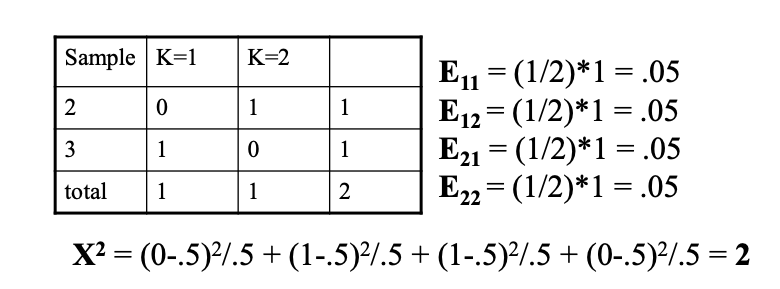

Here I have to note that it is not a real statistical test because there are some constraints for Pearson's chi-squared test (we need more observations in each cell). But since we don't compute the p-value it is not very crucial. Apart from that, it's better to initialize bins with much more instances in each one in real-life cases.

OK, we have calculated statistics for all the pairs. There is a zero division problem for when adjacent bins have equal target distribution but we skip it and consider Pearson's distance is zero in these cases.

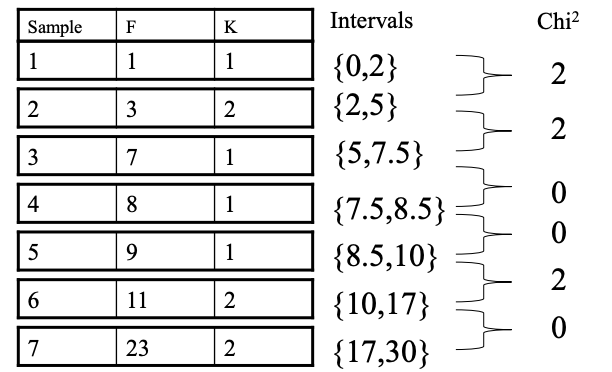

We merge the most similar bins (with minimal chi-squared) and recalculate statistics and repeat and repeat again until we have stepped some predefined threshold for the greatest chi-square distance. One could use p-value to set this threshold but it is important to remember about mentioned constraints.

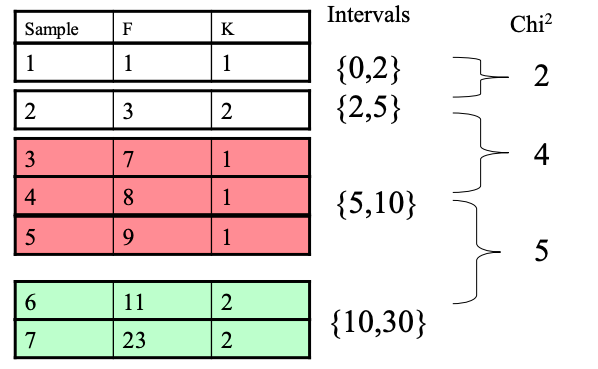

It is possible to apply another statistical test or other similarity measures. However, the main idea of optimal statistical binning is splitting the characteristic possible answer set into intervals which have the most different good-bad proportion.

The described approach is widespread but it is not only one. There are tree-based algorithms: conditional inference trees or traditional decision trees with information gain as splitting criteria.

If we have strong prior knowledge that the bad rate (or target rate, bad clients percentage) will be monotone in some variable then the best way is using Maximum likelihood monotone coarse classifier (MLMCC). It provides a strict linear dependence between predictor and bad rate i.e. the maximum likelihood splitting in full concordance with its name.

OK, I hope you feel that there is not any rocket science in binning. So feel free to be an artist. You can combine some of these methods to do your best for decision your own task. Links to the useful sources where you can get more detail are in the references at the end of the tutorial.

## WoE & IV

Weight of evidence (WoE) and Information Value (IV) are the most commonly used metrics for evaluation binning results.
WoE is calculated for each separate bin and shows how much does target distribution in the bin distinct from distribution on the whole train set:

$$\displaystyle WoE_i = \ln\left((\frac{G_i}{\sum\limits_{i=1}^n{G_i}}) / (\frac{B_i}{\sum\limits_{i=1}^n{B_i}}
)\right)$$

Here $\sum{G_i}$ and $\sum{B_i}$ are amounts of good and bad instances in the ith bin. Obviously, if we put random samples in the bin we would get nearly the same distribution in it and WoE would be zero. The WoE range is from -inf to +inf, so it presents how far is our bin from just a random sample.

To evaluate the predictive power of whole binned predictor one should use IV:

$$\displaystyle IV = \sum\limits_{i=1}^n{\left(WoE_i*(\frac{G_i}{\sum\limits_{i=1}^n{G_i}}-\frac{B_i}{\sum\limits_{i=1}^n{B_i}})\right)}$$

By convention, we have some simple rules for predictor IV values: 
- less than 0.02: not useful predictor;
- 0.02 to 0.1: weak predictor;
- 0.1 to 0.3: medium predictor;
- 0.3 to 0.5: strong predictor;
- more than 0.5: suspicious predictor (should be checked for data leakage or some other mistakes).

So, we can evaluate, compare and select features using IV.

Another noteworthy trick is WoE-encoding of binned categorical predictors. It allows avoiding dataset explosion with a lot of dummy variables and it is similar to the target encoding technique. We just need to write in every bin its WoE value and launch logistic regression.

## Python Implementation

When I faced with binning at my job (of course, it's a bank) I was surprised that there wasn't suitable open source packages for it in Python. So I've coded it myself.

In the following steps, we will implement binning transformer class from scratch and check can it be useful for decision a binary classification task.

In [1]:
#prerequirements
import pandas as pd
import pandas_profiling as pdpr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as ss
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style="darkgrid")

The basis of the implemented class is the optimal statistical binning algorithm was described in the second point. We just use Fisher's exact test instead of Pearson's chi-squared test to avoid all the constraints and approximations and compute p-value directly. Hence in this implementation merge criteria is p-value (instead chi-squared distance), i.e. probability to observe the same or greater difference between good-bad distributions in adjacent bins when they have the same distribution actually.

Also, the following algorithm is designed for a binning of discrete numeric variables like a number of full years or a number of site visiting per week and so on. For continuous numerical features, only bins initialization step could be changed to splitting a range into a large user-defined number of equal size intervals. So I think there is no problem to modify it for your own needs.

In [2]:
class DiscreteBinTransformer(object):
    
    #variables of instance state by default 
    fitted = False #fitted or not fitted yet
    report_table = None #contains binning results
    data = None #contains raw data for binning: only feature and target
    na_size = None #contains number of NaN values in feature
    
    def __init__(self, p_threshold, binsize_threshold):
        self.p_threshold = p_threshold #critical p-value for stopping merging
        #also, we have to state minimal size of a bin to get rid of
        #any tiny unrepresentative bins
        #it's recommended 5% observations in each bin at least
        self.binsize_threshold = binsize_threshold
    
    #search for our bins optimal split-points
    def fit(self, df, feat, target):
        self.feat = feat
        self.target = target
        self.df = df
        
        #preprocessing
        data = df[[feat, target]]
        data.sort_values(feat, inplace=True)
        data.reset_index(drop=True, inplace=True)
        na_size = len(data[data[feat].apply(np.isnan)==True])
        if na_size > 0:
            #cut out the NaN values
            #we have to merge them separately
            data_na = data.iloc[len(data)-len(data[data[feat].apply(np.isnan)==True]):]
            data = data.iloc[:len(data)-len(data[data[feat].apply(np.isnan)==True])]
            data.reset_index(drop=True, inplace=True)

        #initialization of bins
        
        #create blank report table
        #bottom_idx, top_idx - indicies of bottom and top of the bin, to be deleted
        #bottom, top - feature values in bottom_idx and top_idx
        #0, 1 - number of 0/1 instances in the bin
        #p-value - p-value between this row bin and next row bin
        #NA_p-value - p-value between this row bin and NaN values bin, to be deleted
        #NA_flg - 1 if we merge this row bin with NaN values bin else 0
        #         if na_size = 0 all cells are 1
        #WoE, TR, IV - Weight of evidence and target rate for each bin, IV for whole feature
        p_df= pd.DataFrame(columns=['bottom_idx', 'top_idx', 'bottom', 'top', 0, 1, 'p-value',
                                    'NA_p-value', 'NA_flg','WoE', 'TR', 'IV'])
        
        #put only one feature value in every bin
        k=0
        for i in range(int(data[feat].min()), int(data[feat].max())+1):
            group = data.groupby(feat).count()
            if i==data[feat].min():
                p_df.loc[k, 'bottom_idx'] = 0
                p_df.loc[k, 'top_idx'] = group.loc[i].values[0]-1
                p_df.loc[k, 'bottom'] = i
                p_df.loc[k, 'top'] = i
                k+=1
            else:
                if i in group.index:
                    p_df.loc[k, 'bottom_idx'] = group.iloc[:len(group.loc[:i])-1].sum().values[0]
                    p_df.loc[k, 'top_idx'] = group.loc[:i].sum().values[0]-1
                    p_df.loc[k, 'bottom'] = i
                    p_df.loc[k, 'top'] = i
                    k+=1
                else:
                    p_df.loc[k, 'bottom_idx'] = None
                    p_df.loc[k, 'top_idx'] = None
                    p_df.loc[k, 'bottom'] = i
                    p_df.loc[k, 'top'] = i
                    k+=1
                    
        #count 1/0 distribution in each bin
        for j in range(len(p_df)):
            if p_df.loc[j, 'bottom_idx']==None:
                for i in range(2):
                    p_df.loc[j, i] = 0
            else:
                for i in range(2):
                    try:
                        p_df.loc[j, i] = data.loc[p_df.loc[j, 'bottom_idx']:p_df.loc[j, 'top_idx'], target].value_counts()[i]
                    except KeyError:
                        p_df.loc[j, i] = 0        
        
        #drop indecies, we don't need it more
        p_df.drop(labels=['bottom_idx', 'top_idx'], axis=1, inplace=True)
        
        #compute p-values
        for i in range(len(p_df)-1):
            p_df.loc[i, 'p-value'] = ss.fisher_exact([[p_df.loc[i, 0], p_df.loc[i, 1]], [p_df.loc[i+1, 0], p_df.loc[i+1, 1]]])[1]
        
        k=0 #counter for detecting the first repeat
        na_p_increased = False #True if there were not enough instances
                               #in NaN values bin in the previous repeat
        
        #let's start p-merging!
        while True:
            #merge bins until the greatest p-value is less than threshold
            #don't count NaN bin in the first repeat
            while p_df[p_df['p-value']==p_df['p-value'].max()]['p-value'].values[0] > self.p_threshold:
                pmax_idx = p_df[p_df['p-value']==p_df['p-value'].max()]['p-value'].index[0]
                p_df.loc[pmax_idx, 'top'] = p_df.loc[pmax_idx+1, 'top']
                p_df.loc[pmax_idx, 0] = p_df.loc[pmax_idx, 0] + p_df.loc[pmax_idx+1, 0]
                p_df.loc[pmax_idx, 1] = p_df.loc[pmax_idx, 1] + p_df.loc[pmax_idx+1, 1]
                if na_size > 0 and k > 0:
                    p_df.loc[pmax_idx, 'NA_flg'] = p_df.loc[pmax_idx, 'NA_flg'] + p_df.loc[pmax_idx+1, 'NA_flg']
                p_df.drop(axis=0, index=pmax_idx+1, inplace=True)
                p_df.reset_index(drop=True, inplace=True)
                p_df['p-value'] = None
                for i in range(len(p_df)-1):
                    p_df.loc[i, 'p-value'] = ss.fisher_exact([[p_df.loc[i, 0], p_df.loc[i, 1]], [p_df.loc[i+1, 0], p_df.loc[i+1, 1]]])[1]

            #NaN-merging in the first repeat
            #We separate the first repeat
            #because we have to compute p-values between NaN bin and each other bin
            #In other repeats we don't always have to recompute them
            if na_size > 0 and k==0:
                p_df.loc[len(p_df), 'bottom'] = 'N/A'
                p_df.loc[len(p_df)-1, 'top'] = 'N/A'
                for i in range(2):
                    p_df.loc[len(p_df)-1, i] = data_na[target].value_counts()[i]
                for i in range(len(p_df)-1):    
                    p_df.loc[i, 'NA_p-value'] = ss.fisher_exact([[p_df.loc[i, 0], p_df.loc[i, 1]], [p_df.loc[len(p_df)-1, 0], p_df.loc[len(p_df)-1, 1]]])[1]
                #NaN bin should be merged with one of other bins
                if p_df['NA_p-value'].max() > self.p_threshold:
                    na_pmax_idx = p_df[p_df['NA_p-value']==p_df['NA_p-value'].max()].index[0]
                    p_df.loc[na_pmax_idx, 0] = p_df.loc[na_pmax_idx, 0] + p_df.loc[len(p_df)-1, 0]
                    p_df.loc[na_pmax_idx, 1] = p_df.loc[na_pmax_idx, 1] + p_df.loc[len(p_df)-1, 1]
                    p_df.drop(axis=0, index=len(p_df)-1, inplace=True)
                    p_df.drop(axis=1, columns=['NA_p-value'], inplace=True)
                    p_df['NA_flg'] = 0
                    p_df.loc[na_pmax_idx, 'NA_flg'] = 1
                    #we have to recompute all p-values after merging
                    for i in range(len(p_df)-1):
                        p_df.loc[i, 'p-value'] = ss.fisher_exact([[p_df.loc[i, 0], p_df.loc[i, 1]], [p_df.loc[i+1, 0], p_df.loc[i+1, 1]]])[1]
                    #merge bins until max p-value is less than threshold again
                    while p_df[p_df['p-value']==p_df['p-value'].max()]['p-value'].values[0] > self.p_threshold:
                        pmax_idx = p_df[p_df['p-value']==p_df['p-value'].max()]['p-value'].index[0]
                        p_df.loc[pmax_idx, 'top'] = p_df.loc[pmax_idx+1, 'top']
                        p_df.loc[pmax_idx, 0] = p_df.loc[pmax_idx, 0] + p_df.loc[pmax_idx+1, 0]
                        p_df.loc[pmax_idx, 1] = p_df.loc[pmax_idx, 1] + p_df.loc[pmax_idx+1, 1]
                        p_df.loc[pmax_idx, 'NA_flg'] = p_df.loc[pmax_idx, 'NA_flg'] + p_df.loc[pmax_idx+1, 'NA_flg']
                        p_df.drop(axis=0, index=pmax_idx+1, inplace=True)
                        p_df.reset_index(drop=True, inplace=True)
                        p_df['p-value'] = None
                        for i in range(len(p_df)-1):
                            p_df.loc[i, 'p-value'] = ss.fisher_exact([[p_df.loc[i, 0], p_df.loc[i, 1]], [p_df.loc[i+1, 0], p_df.loc[i+1, 1]]])[1]
                #NaN bin shouldn't be merged
                else:
                    p_df['NA_flg'] = 0       
            #NaN-merging in the other repeats        
            elif na_size > 0:
                #condition: NaN bin hasn't merged in the previous repeat
                if p_df['NA_flg'].max() == 0:
                    if not na_p_increased:
                        for i in range(len(p_df)-1):    
                            p_df.loc[i, 'NA_p-value'] = ss.fisher_exact([[p_df.loc[i, 0], p_df.loc[i, 1]], [p_df.loc[len(p_df)-1, 0], p_df.loc[len(p_df)-1, 1]]])[1]
                    if p_df['NA_p-value'].max() > self.p_threshold:
                        na_pmax_idx = p_df[p_df['NA_p-value']==p_df['NA_p-value'].max()].index[0]
                        p_df.loc[na_pmax_idx, 0] = p_df.loc[na_pmax_idx, 0] + p_df.loc[len(p_df)-1, 0]
                        p_df.loc[na_pmax_idx, 1] = p_df.loc[na_pmax_idx, 1] + p_df.loc[len(p_df)-1, 1]
                        p_df.drop(axis=0, index=len(p_df)-1, inplace=True)
                        p_df.drop(axis=1, columns=['NA_p-value'], inplace=True)
                        p_df['NA_flg'] = 0
                        p_df.loc[na_pmax_idx, 'NA_flg'] = 1
                        #we have to recompute all p-values after merging
                        for i in range(len(p_df)-1):
                            p_df.loc[i, 'p-value'] = ss.fisher_exact([[p_df.loc[i, 0], p_df.loc[i, 1]], [p_df.loc[i+1, 0], p_df.loc[i+1, 1]]])[1]
                        #merge bins until max p-value is less than threshold again
                        while p_df[p_df['p-value']==p_df['p-value'].max()]['p-value'].values[0] > self.p_threshold:
                            pmax_idx = p_df[p_df['p-value']==p_df['p-value'].max()]['p-value'].index[0]
                            p_df.loc[pmax_idx, 'top'] = p_df.loc[pmax_idx+1, 'top']
                            p_df.loc[pmax_idx, 0] = p_df.loc[pmax_idx, 0] + p_df.loc[pmax_idx+1, 0]
                            p_df.loc[pmax_idx, 1] = p_df.loc[pmax_idx, 1] + p_df.loc[pmax_idx+1, 1]
                            p_df.loc[pmax_idx, 'NA_flg'] = p_df.loc[pmax_idx, 'NA_flg'] + p_df.loc[pmax_idx+1, 'NA_flg']
                            p_df.drop(axis=0, index=pmax_idx+1, inplace=True)
                            p_df.reset_index(drop=True, inplace=True)
                            p_df['p-value'] = None
                            for i in range(len(p_df)-1):
                                p_df.loc[i, 'p-value'] = ss.fisher_exact([[p_df.loc[i, 0], p_df.loc[i, 1]], [p_df.loc[i+1, 0], p_df.loc[i+1, 1]]])[1]
            
            #na_size = 0, there are no NaN values
            else:
                p_df['NA_flg'] = 1 #set NA_flg column to 1 to distinct this case
                if k==0:
                    p_df.drop(axis=1, columns=['NA_p-value'], inplace=True)

            #small bins processing
            binsize_df = p_df[0]+p_df[1]
            #when min bin size is less than the threshold
            #then increase its p-value by 1 and repeat merging
            #else end up merging
            if binsize_df.min()/len(df) < self.binsize_threshold:
                minsize_idx = binsize_df[binsize_df==binsize_df.min()].index[-1]
                if minsize_idx == 0:
                    p_df.loc[minsize_idx, 'p-value'] += 1
                    na_p_increased = False
                elif minsize_idx in range(len(p_df)-2):
                    if p_df.loc[minsize_idx, 'p-value'] > p_df.loc[minsize_idx-1, 'p-value']:
                        p_df.loc[minsize_idx, 'p-value'] += 1
                        na_p_increased = False
                    else:
                        p_df.loc[minsize_idx-1, 'p-value'] +=1
                        na_p_increased = False
                elif minsize_idx == len(p_df)-2:
                    if p_df['NA_flg'].max() == 0:
                        p_df.loc[minsize_idx-1, 'p-value'] += 1
                        na_p_increased = False
                    else:
                        if p_df.loc[minsize_idx, 'p-value'] > p_df.loc[minsize_idx-1, 'p-value']:
                            p_df.loc[minsize_idx, 'p-value'] += 1
                            na_p_increased = False
                        else:
                            p_df.loc[minsize_idx-1, 'p-value'] +=1
                            na_p_increased = False
                elif minsize_idx == len(p_df)-1:
                    if p_df['NA_flg'].max() == 0:
                        p_df.loc[p_df[p_df['NA_p-value']==p_df.loc[:len(p_df)-2, 'NA_p-value'].max()].index[0], 'NA_p-value'] += 1
                        na_p_increased = True        
                    else:
                        p_df.loc[minsize_idx-1, 'p-value'] += 1
                        na_p_increased = False
                k+=1
                continue
            else:
                break
        
        #Weight of Evidence & Information Value & Target Rate computation
        p_df['TR'] = p_df[1]/(p_df[0]+p_df[1])
        for i in range(len(p_df)):
            p_df.loc[i, 'WoE'] = np.log((p_df.loc[i, 0]/p_df[0].sum())/(p_df.loc[i, 1]/p_df[1].sum()))
        p_df.loc[0, 'IV'] = 0
        for i in range(len(p_df)):
            p_df.loc[0, 'IV'] += p_df.loc[i, 'WoE']*((p_df.loc[i, 0]/p_df[0].sum()) - (p_df.loc[i, 1]/p_df[1].sum()))
        
        #results saving
        self.fitted = True
        self.report_table = p_df
        self.data = data
        self.na_size = na_size
        
        return p_df #completed report table

    #woe encoding of full /train + test/ dataset
    def woe_transform(self, df):
        if not self.fitted:
            print('Not fitted yet')
        else:
            p_df = self.report_table
            
            #number of bin defining for the feature value
            def num_of_bin(x):
                if self.na_size > 0:
                    if p_df['NA_flg'].max() == 0:
                        if x<=p_df.loc[0, 'top']:
                            return 0
                        for i in range(1, len(p_df)-2):
                            if x<=p_df.loc[i, 'top'] and x>p_df.loc[i-1, 'top']:
                                return i
                        if x > p_df.loc[len(p_df)-3, 'top']:
                            return len(p_df)-2
                        if np.isnan(x):
                            return len(p_df)-1
                    else:
                        if p_df.loc[0, 'NA_flg'] == 1:
                            if x<=p_df.loc[0, 'top'] or np.isnan(x):
                                return 0
                        else:
                            if x<=p_df.loc[0, 'top']:
                                return 0
                        for i in range(1, len(p_df)-1):
                            if p_df.loc[i, 'NA_flg'] == 1:
                                if x<=p_df.loc[i, 'top'] and x>p_df.loc[i-1, 'top'] or np.isnan(x):
                                    return i
                            else:
                                if x<=p_df.loc[i, 'top'] and x>p_df.loc[i-1, 'top']:
                                    return i
                        if p_df.loc[len(p_df)-1, 'NA_flg'] == 1:
                            if x > p_df.loc[len(p_df)-2, 'top'] or np.isnan(x):
                                return len(p_df)-1
                        else:
                            if x > p_df.loc[len(p_df)-2, 'top']:
                                return len(p_df)-1
                else:
                    if x<=p_df.loc[0, 'top']:
                        return 0
                    for i in range(1, len(p_df)-1):
                        if x<=p_df.loc[i, 'top'] and x>p_df.loc[i-1, 'top']:
                            return i
                    if x > p_df.loc[len(p_df)-2, 'top']:
                        return len(p_df)-1
            
            woe_list = [p_df.loc[i, 'WoE'] for i in range(len(p_df))]
            
            df_clone = df.copy()
            df_clone['woe_%s' % self.feat] = df_clone[self.feat].apply(lambda x: woe_list[num_of_bin(x)])
            df_clone.drop(self.feat, axis=1, inplace=True)
            
            return df_clone

This algorithm can seem scary but actually, it is quite clear. We initialize bins, compute p-values, merge without NaN values, then compute p-values and merge NaN values. If some bin is too small we increase its p-value by one. After every merging, we have to recompute p-values.

OK, let's see how can it help us.

## Let's check it

For model training, we will use data about bank customers and their delinquencies from [Yorko's Git](https://github.com/Yorko/mlcourse.ai).

In [3]:
df = pd.read_csv('./data/credit_scoring_train.csv')
df.head().T

,0,1,2,3,4
client_id,0.000000,1.000000,2.000000,3.000000,4.000000
DIR,0.496289,0.433567,2206.731199,886.132793,0.000000
Age,49.100000,48.000000,55.500000,55.300000,52.300000
NumLoans,13.000000,9.000000,21.000000,3.000000,1.000000
NumRealEstateLoans,0.000000,2.000000,1.000000,0.000000,0.000000
NumDependents,0.000000,2.000000,NaN,0.000000,0.000000
Num30-59Delinquencies,2.000000,1.000000,1.000000,0.000000,0.000000
Num60-89Delinquencies,0.000000,0.000000,0.000000,0.000000,0.000000
Income,5298.360639,6008.056256,NaN,NaN,2504.613105
BalanceToCreditLimit,0.387028,0.234679,0.348227,0.971930,1.004350


In [4]:
#very quick glance through the data
pdpr.ProfileReport(df)

Number of variables,11
Number of observations,75000
Total Missing (%),2.0%
Total size in memory,6.3 MiB
Average record size in memory,88.0 B
Numeric,9
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,1


Obviously, the target variable is Delinquent90 (Does customer have 90+ delinquency or doesn't).

Let's try to bin one of the discrete features - NumLoans. 

In [5]:
binner = DiscreteBinTransformer(p_threshold=0.01, binsize_threshold=0.05)
report_df = binner.fit(df=df, feat='NumLoans', target='Delinquent90')
report_df

,bottom,top,0,1,p-value,NA_flg,WoE,TR,IV
0,0,2,5742,857,4.39338e-20,1,-0.73415,0.129868,0.0871187
1,3,3,4203,345,3.41464e-05,1,-0.136266,0.075858,NaN
2,4,7,24044,1519,0.000559719,1,0.125558,0.059422,NaN
3,8,8,6009,305,0.00431128,1,0.344427,0.048305,NaN
4,9,13,19731,1208,7.25093e-06,1,0.15695,0.057691,NaN
5,14,56,10258,779,None,1,-0.0584729,0.070581,NaN


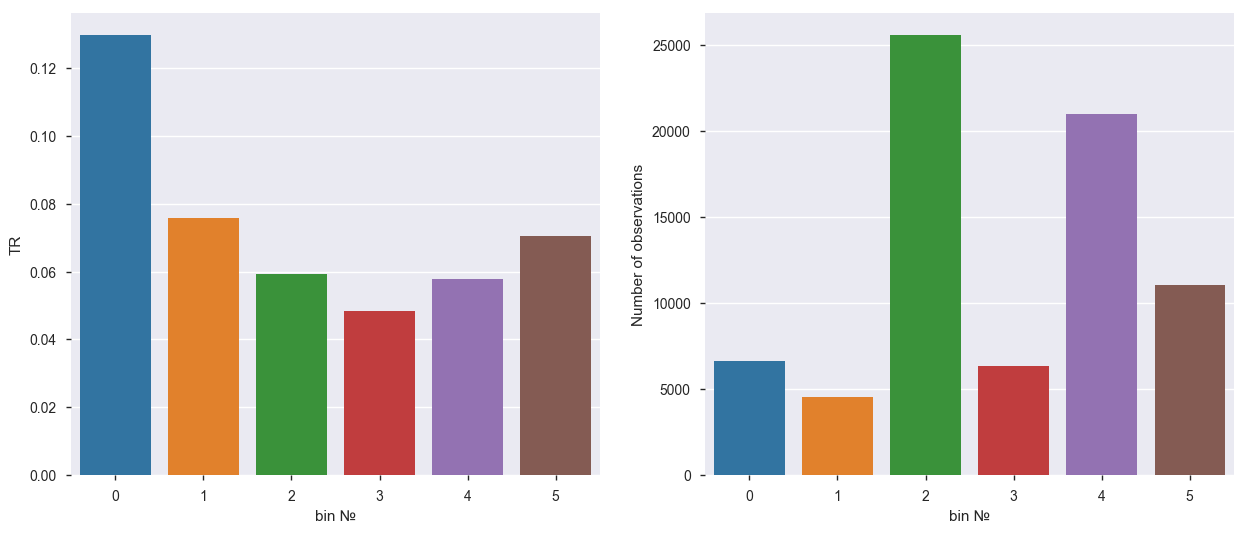

In [6]:
vis = pd.DataFrame(data=report_df[['TR', 0, 1, 'WoE']], index=report_df.index)
vis['bin №'] = report_df.index
vis['Number of observations'] = vis[0] + vis[1]

_, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.barplot(data=vis, x='bin №', y='TR', ax=axes[0])
sns.barplot(data=vis, x='bin №', y='Number of observations', ax=axes[1]);

So, we got six bins for this feature. Variable has weak predictive power (IV is less than 0.1). We observe strong non-monotonicity between predictor and target rate. Hence we can expect that logistic regression will get better results with the binned variable.

For clarity, let's make some visualisation.

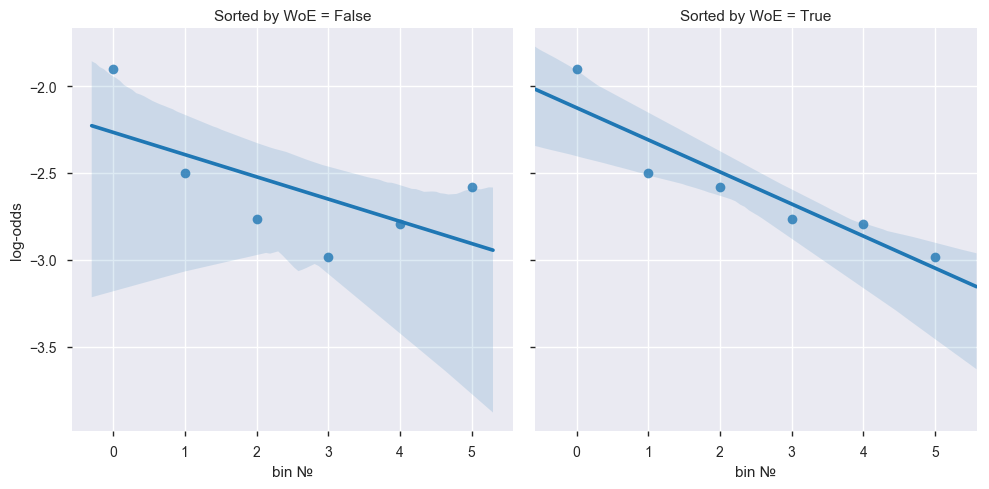

In [7]:
vis1 = vis[['bin №', 'WoE', 'TR']]
vis1['log-odds'] = vis1['TR'].apply(lambda x: np.log(x/(1-x)))
vis2 = vis1.sort_values('WoE').reset_index(drop=True).drop('bin №', axis=1)
vis2['bin №'] = vis2.index
vis2['Sorted by WoE'] = True
vis1['Sorted by WoE'] = False
vis_comp = pd.concat([vis1, vis2], axis=0)
sns.lmplot(x="bin №", y="log-odds", col="Sorted by WoE", data=vis_comp);

If we built logistic regression with raw data, we would suppose linear dependence between feature and log-odds automatically. It involves the big loss as we see on the left figure. WoE encoding allows us to mitigate this loss and build a much more precise model as WoE is always inversely proportional to the target rate and hence to log-odds. Here we suppose that the target rate is equal to the probability of default for every customer in this bin.

It's time for modelling!

In [8]:
lr = LogisticRegression(random_state=19)
skf =StratifiedKFold(n_splits=10, shuffle=True, random_state=19)

To evaluate the binning contribution to a model quality we compare results of both single factor logistic regressions: with binned WoE-encoded variable and with the raw one.

Let's get ROC-AUC score for the ordinary model on cross-validation.

In [9]:
raw_data = df[['NumLoans', 'Delinquent90']].dropna()
raw_cv_score = cross_val_score(lr, raw_data['NumLoans'].values.reshape(-1, 1), 
                               raw_data['Delinquent90'], cv=skf, scoring='roc_auc')
print('Mean ROC-AUC score with raw data is', np.round(raw_cv_score.mean(), 4))

Mean ROC-AUC score with raw data is 0.5457


We have to build the appropriate pipeline for proper evaluation of model based on WoE transformed data. We should fit our binner with train folds only in every cross-validation step to avoid data leakage.

In [10]:
data = df[['NumLoans', 'Delinquent90']]
woe_cv_score = []

for train_idx, test_idx in skf.split(X=data['NumLoans'], y=data['Delinquent90']):
    
    #get training folds
    f_data = data.loc[train_idx] 
    
    #fit binner on the training folds
    binner = DiscreteBinTransformer(p_threshold=0.01, binsize_threshold=0.05)
    rdf = binner.fit(df=f_data, feat='NumLoans', target='Delinquent90')
    
    #transform full dataset
    t_data = binner.woe_transform(data)
    
    #prepare data for logistic regression
    X = t_data['woe_%s' % 'NumLoans']
    y = t_data['Delinquent90']
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    #train model and get score
    lr.fit(X_train.values.reshape(-1, 1), y_train)
    y_pred = lr.predict_proba(X_test.values.reshape(-1, 1))[:,1]
    woe_cv_score += [roc_auc_score(y_test, y_pred)]

In [11]:
print('Mean ROC-AUC score with binned data is', np.round(np.mean(woe_cv_score), 4))

Mean ROC-AUC score with binned data is 0.5603


Wow, we got notable quality improvement! Let's ensure it's not just a coincidence. We use the Shapiro–Wilk test of normality of cross-validation scores list and Student's t-test for mean scores comparison.

In [12]:
print(' Probability for raw data:    ', ss.shapiro(raw_cv_score)[1], '\n',
      'Probability for binned data: ', ss.shapiro(woe_cv_score)[1])

 Probability for raw data:     0.8475636839866638 
 Probability for binned data:  0.41602033376693726


Probability to observe such or greater difference when actually, cross-validation scores are distributed equally:

In [13]:
print('P-value is', np.round(ss.ttest_ind(raw_cv_score, woe_cv_score)[1], 3))

P-value is 0.035


## Conclusion

It's very cool and competitive to be familiar with advanced algorithms of the boosting or neural networks, but sometimes in industry analysts prefer more steady, transparency and interpretable linear models at least as a baseline.

Binning technique is a powerful tool which can solve most of your problems with linear models just in one touch: outliers, missing values, non-monotonicity, feature selection and maybe you will find some insights about feature engineering after binning results plotting.

I would be happy if I found a similar article when I started to search for information to understand what is the binning and how I could implement it in Python. And I hope it was useful for you or informatively at least.

## References

1. Mironchyk, Tchistiakov. Monotone optimal binning algorithm for credit risk modelling ([link](https://www.researchgate.net/publication/322520135_Monotone_optimal_binning_algorithm_for_credit_risk_modeling)) - clarifies the binning basics, makes a comparative analysis of different algorithms and provides the original one.
2. Thomas, Edelman, Crook. Credit Scoring and Its Applications (§8.7 Coarse classifying the characteristics) - different statistical approaches and MLMCC (maximum likelihood method).
3. Siddiqi. Intelligent Credit Scoring (paragraph 'Initial Characteristic Analysis', p. 179) - some more information.

All these books and some other materials you can get [here](https://yadi.sk/d/-cwR_xXd3G6IOA).